# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [14]:
##Sorting data for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


final = time_sorted_data.take(np.random.permutation(len(final))[:50000])
print(final.shape)
final.head()

(50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
83782,91170,B000P3ZJ2Q,A2RUVBPNRYICVB,Deborah1018,0,0,1,1337731200,Deborah1018,they where exactly what they said I sent them ...
91251,99262,B0009ETA76,A3FQ9T2G2GMRX1,Carly,0,0,1,1244419200,Increased milk supply,My doctor recommended that I try Fenugreek to ...
87453,95191,B003UEKFS0,AC299UUMA6MYG,zen,1,1,1,1310860800,zen,i don't like black tea because they have a bit...
71821,78193,B001BM399U,A3LWIP2I6550TB,X. Nguyen,0,0,1,1320364800,Best baby food out there!,Earth's Best makes the BEST organic baby food ...
51348,55785,B001W40ALW,A36G22F9S9DE91,Jackie,1,1,1,1269561600,Best Olives Ever!,My daughter and I are addicted to these olives...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

they where exactly what they said I sent them to my mom for mothers day and she loved them they lasted for over a week she loved them.  They where worth every cent I payed for them she had a smile on her face everytime she looked at them by the way tulips are her favorite flower I will buy from them again they where delivered when they said and they where as pretty as the picture I also like the why they where delivered they came in a box tulips in one and the vase in another so she could make it they way she wanted to they are awesome I love them they made my moms mother day very special thank you so much from a very Happy customer will order again.
Definetly my favorite coffee sold by Amazon. Just bought 4 lbs. for 8 bucks a pound which is my coffee deal of the year.
This hot sauce is no joke.  I've loved spicy food since before I could walk, and can't remember ever eating anything half as potent as this sauce.  I put a couple of drops of this stuff in nearly everything I eat, not on

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

they where exactly what they said I sent them to my mom for mothers day and she loved them they lasted for over a week she loved them.  They where worth every cent I payed for them she had a smile on her face everytime she looked at them by the way tulips are her favorite flower I will buy from them again they where delivered when they said and they where as pretty as the picture I also like the why they where delivered they came in a box tulips in one and the vase in another so she could make it they way she wanted to they are awesome I love them they made my moms mother day very special thank you so much from a very Happy customer will order again.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

they where exactly what they said I sent them to my mom for mothers day and she loved them they lasted for over a week she loved them.  They where worth every cent I payed for them she had a smile on her face everytime she looked at them by the way tulips are her favorite flower I will buy from them again they where delivered when they said and they where as pretty as the picture I also like the why they where delivered they came in a box tulips in one and the vase in another so she could make it they way she wanted to they are awesome I love them they made my moms mother day very special thank you so much from a very Happy customer will order again.
Definetly my favorite coffee sold by Amazon. Just bought 4 lbs. for 8 bucks a pound which is my coffee deal of the year.
This hot sauce is no joke.  I've loved spicy food since before I could walk, and can't remember ever eating anything half as potent as this sauce.  I put a couple of drops of this stuff in nearly everything I eat, not on

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This hot sauce is no joke.  I have loved spicy food since before I could walk, and can not remember ever eating anything half as potent as this sauce.  I put a couple of drops of this stuff in nearly everything I eat, not only is it incredibly hot, but it has a really nice flavor to it as well.  Just be careful, like the label warns, you can clean oil stains on your driveway w/ this stuff.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

they where exactly what they said I sent them to my mom for mothers day and she loved them they lasted for over a week she loved them.  They where worth every cent I payed for them she had a smile on her face everytime she looked at them by the way tulips are her favorite flower I will buy from them again they where delivered when they said and they where as pretty as the picture I also like the why they where delivered they came in a box tulips in one and the vase in another so she could make it they way she wanted to they are awesome I love them they made my moms mother day very special thank you so much from a very Happy customer will order again.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This hot sauce is no joke I have loved spicy food since before I could walk and can not remember ever eating anything half as potent as this sauce I put a couple of drops of this stuff in nearly everything I eat not only is it incredibly hot but it has a really nice flavor to it as well Just be careful like the label warns you can clean oil stains on your driveway w this stuff 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
prepr_rev = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    prepr_rev.append(sentance.strip())

100%|██████████| 50000/50000 [00:24<00:00, 2069.51it/s]


In [24]:
prepr_rev[1500]

'hot sauce no joke loved spicy food since could walk not remember ever eating anything half potent sauce put couple drops stuff nearly everything eat not incredibly hot really nice flavor well careful like label warns clean oil stains driveway w stuff'

In [25]:
print(len(prepr_rev))
final.shape

50000


(50000, 10)

In [26]:
final ['prepr_rev']= prepr_rev
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,prepr_rev
83782,91170,B000P3ZJ2Q,A2RUVBPNRYICVB,Deborah1018,0,0,1,1337731200,Deborah1018,they where exactly what they said I sent them ...,exactly said sent mom mothers day loved lasted...
91251,99262,B0009ETA76,A3FQ9T2G2GMRX1,Carly,0,0,1,1244419200,Increased milk supply,My doctor recommended that I try Fenugreek to ...,doctor recommended try fenugreek increase milk...
87453,95191,B003UEKFS0,AC299UUMA6MYG,zen,1,1,1,1310860800,zen,i don't like black tea because they have a bit...,not like black tea bitter taste love tea reall...
71821,78193,B001BM399U,A3LWIP2I6550TB,X. Nguyen,0,0,1,1320364800,Best baby food out there!,Earth's Best makes the BEST organic baby food ...,earth best makes best organic baby food ever f...
51348,55785,B001W40ALW,A36G22F9S9DE91,Jackie,1,1,1,1269561600,Best Olives Ever!,My daughter and I are addicted to these olives...,daughter addicted olives blue cheese clearly b...


In [27]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
conn.close()
#Loading data
conn = sqlite3.connect('final.sqlite')
data=pd.read_sql_query("""select * from Reviews""",conn)

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
from sklearn.model_selection import train_test_split
#splitting data into Train, C.V and Test
X_train, X_test, y_train, y_test = train_test_split(final ['prepr_rev'], final['Score'], test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print("Train:",X_train.shape,y_train.shape)
print("CV:",X_cv.shape,y_cv.shape)
print("Test:",X_test.shape,y_test.shape)

Train: (22445,) (22445,)
CV: (11055,) (11055,)
Test: (16500,) (16500,)


In [29]:
vectorizer = CountVectorizer(min_df=10, max_features=500) 
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 
 

After vectorizations
(22445, 500) (22445,)
(11055, 500) (11055,)
(16500, 500) (16500,)


## [4.3] TF-IDF

In [30]:
vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect = vect.fit(X_train)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test) 
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape) 
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape) 

After vectorizations
(22445, 500) (22445,)
(11055, 500) (11055,)
(16500, 500) (16500,)


## [4.4] Word2Vec

In [31]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

[('good', 0.8064497113227844), ('excellent', 0.7870410680770874), ('awesome', 0.7711895108222961), ('amazing', 0.7595717906951904), ('fantastic', 0.7512704730033875), ('wonderful', 0.7327049970626831), ('perfect', 0.7319329380989075), ('terrific', 0.7159024477005005), ('especially', 0.6756550073623657), ('decent', 0.6587969660758972)]
[('smoothest', 0.8289793729782104), ('horrible', 0.7650426626205444), ('ever', 0.7644084692001343), ('agree', 0.7450532913208008), ('closest', 0.7399212718009949), ('surpasses', 0.7325074076652527), ('best', 0.7249419689178467), ('ive', 0.722728967666626), ('mead', 0.7177785634994507), ('awful', 0.7149074077606201)]
number of words that occured minimum 5 times  9150


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9150
sample words  ['bars', 'tasty', 'got', 'low', 'sales', 'price', 'much', 'less', 'overpriced', 'usually', 'consider', 'like', 'slightly', 'sweet', 'cookies', 'health', 'not', 'anything', 'wrong', 'come', 'two', 'thin', 'ones', 'per', 'pouch', 'though', 'get', 'total', 'pouches', 'people', 'would', 'one', 'serving', 'getting', 'servings', 'also', 'extremely', 'crumbly', 'suggest', 'something', 'underneath', 'eat', 'catch', 'crumbs', 'vacuum', 'handy', 'car', 'surprised', 'opening', 'package']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [33]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 11055/11055 [00:23<00:00, 472.46it/s]

(11055, 50)
[ 0.11423624  0.52322548  0.92737992  0.42657398  0.03149832 -0.49709554
 -0.22744501  0.77123317 -0.8727156   0.49516902  0.65777033 -0.70547067
 -0.31035827  0.61977974  0.3090385   0.31754157  0.11933282  0.53610293
 -0.14034547 -0.36208856 -0.5970275   0.14536198  0.69747322 -0.05873975
  0.4705957  -0.96374629 -0.80560572  0.76205894  0.02416955 -0.26141378
  1.30679555  0.44071176 -0.02415145 -0.39271318  0.37185064  0.41067095
  1.04710724 -0.16281124 -0.99547324 -1.69104051  0.27877323 -0.03820085
  0.34624931  0.13389229  0.0311872   0.67670954 -0.30030563 -0.65574397
 -1.32690578 -0.10916533]


In [35]:
# compute average word2vec for X_test .
test_vectors = []; 
for sent in tqdm(sent_of_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)  
    
test_vectors = np.array(test_vectors)

print(test_vectors.shape)
print(test_vectors[0])    


100%|██████████| 16500/16500 [00:35<00:00, 463.12it/s]

(16500, 50)
[-0.21650994  0.20763936  0.23225507  0.43245629 -0.03147818 -0.34158848
 -0.23489848  0.12679867  0.15458322  0.52804215 -0.32813715 -0.1358679
 -0.02285376 -0.22915929 -0.2054066   0.33587438 -0.28956964 -0.29684678
  0.05607984 -0.19122175  0.05548987  0.22762442  0.54389045 -0.32156981
 -0.21385965 -0.45756952 -0.09783928  0.14551443 -0.48427639  0.15391132
  0.69929648 -0.1097943  -0.14275275 -0.20143936 -0.25195681  0.17130008
  0.31810653 -0.36715548 -0.56052186 -0.52939431  0.56273055 -0.05734205
 -0.01385809 -0.34118139  0.05820298  0.54194045 -0.06114813  0.19944374
 -0.45926711  0.22486217]


In [36]:
# compute average word2vec for X_train .
train_vectors = []; 
for sent in tqdm(sent_of_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
train_vectors = np.array(train_vectors)

print(train_vectors.shape)
print(train_vectors[0])

100%|██████████| 22445/22445 [00:47<00:00, 467.78it/s]

(22445, 50)
[ 0.23795041  0.56482501  0.23975698  0.47662384 -0.03241647 -0.42026585
 -0.0920234   0.60887131  0.10361548  0.69549562 -0.42657898 -0.22850905
  0.10854015 -0.43730003 -0.22391569 -0.11131373 -0.21342933 -0.09610408
 -0.10915289 -0.49629217 -0.10829031  0.36527382  0.78678009 -0.25987415
 -0.59941445  0.05826041 -0.38378821  0.2704506  -0.57303713 -0.18668537
  0.36423239 -0.03373933 -0.12033268  0.11460553 -0.0766927  -0.05885986
  0.27646326 -0.3050041  -0.4903128  -0.87627939  1.16383488  0.10803538
 -0.10990737 -0.79267004  0.08959021  0.62530343 -0.51399749  0.20063627
 -0.29426406  0.25943958]


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    
tfidf_test_vectors = np.array(tfidf_test_vectors)
print(tfidf_test_vectors.shape)
print(tfidf_test_vectors[0])   


100%|██████████| 16500/16500 [06:58<00:00, 39.43it/s]


(16500, 50)
[-0.43023417  0.08085112  0.26280191  0.12586552  0.19083609 -0.18514371
 -0.28463129  0.13400232  0.16023318  0.52938326 -0.43975282 -0.12440866
 -0.11275344 -0.11934448 -0.22762588  0.45164176 -0.39158681 -0.31570446
  0.02818469 -0.17517456  0.02748073  0.26977343  0.52292236 -0.34498091
 -0.00175078 -0.44338077  0.02350666  0.06165066 -0.34236525  0.21216029
  0.78613459 -0.15390468 -0.16417371 -0.32861782 -0.2659092   0.10186823
  0.22447934 -0.40924459 -0.62742319 -0.46896159  0.32371111 -0.00329997
 -0.03767758 -0.31543755  0.09439429  0.46229863  0.03195479  0.27520308
 -0.57627453  0.09213921]


In [38]:
# compute TFIDF Weighted Word2Vec for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)

tfidf_train_vectors = np.array(tfidf_train_vectors)
print(tfidf_train_vectors.shape)
print(tfidf_train_vectors[0])  

100%|██████████| 22445/22445 [07:21<00:00, 50.83it/s]


(22445, 50)
[ 0.40917395  0.51609145  0.30560965  0.35250069  0.00734301 -0.39421347
 -0.09543645  0.728009   -0.09724581  0.85466854 -0.43076187 -0.13585101
 -0.06857081 -0.5797596  -0.27492372 -0.41646634 -0.09126814 -0.117861
 -0.0479078  -0.42574795 -0.31589024  0.4247003   0.86006957 -0.2709104
 -0.50717747  0.32116871 -0.42186319  0.35714914 -0.34300058 -0.36286456
  0.35645985 -0.0755837   0.0781704   0.18814762 -0.08119907 -0.23603788
  0.25133437 -0.37718325 -0.22148637 -0.93937279  1.2041414   0.34071557
 -0.01912081 -1.03047928  0.01094786  0.84018511 -0.55510452  0.20887449
 -0.40060992  0.07882321]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

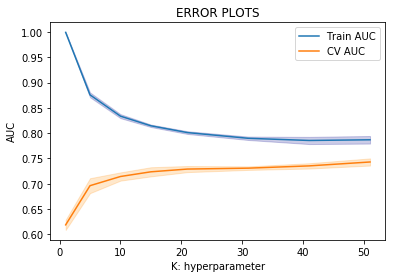

In [130]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_bow, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [218]:
best_k=10

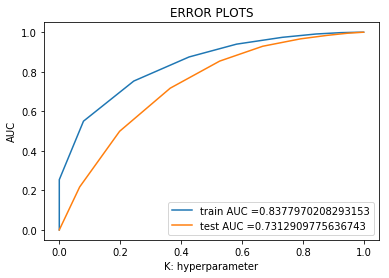

Train confusion matrix
[[ 1524  2125]
 [ 1132 17664]]
Test confusion matrix
[[  882  1777]
 [  981 12860]]


In [219]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_bow, y_train)

    
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))


# Variables for table  
bow_brute_K = best_k
bow_brute_train= train_auc
bow_brute_test = cv_auc

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

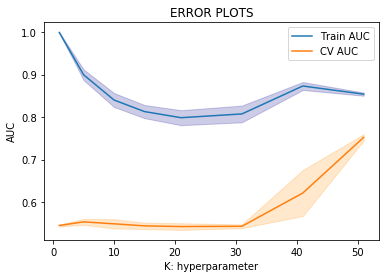

In [105]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV



neigh = KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_tfidf, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [220]:
best_k = 50

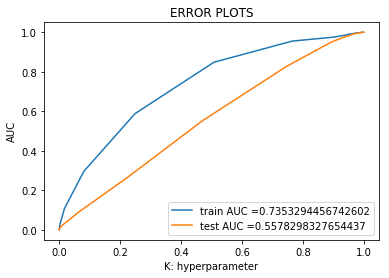

Train confusion matrix
[[    1  3648]
 [    0 18796]]
Test confusion matrix
[[    1  2658]
 [    0 13841]]


In [221]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_tfidf, y_train)
   
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidf)))




# Variables for table 


tfidf_brute_K = best_k
tfidf_brute_train = train_auc
tfidf_brute_test = cv_auc
 

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

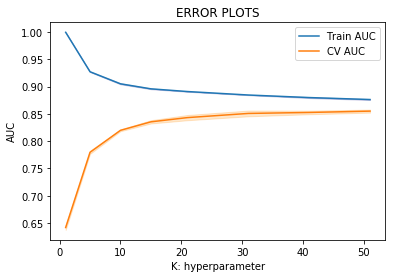

In [48]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(train_vectors, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [222]:
best_k = 15

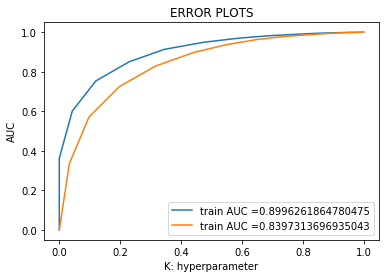

Train confusion matrix
[[ 1135  2514]
 [  333 18463]]
Test confusion matrix
[[  706  1953]
 [  304 13537]]


In [223]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(train_vectors, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(train_vectors)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(test_vectors)))


# Variables for table 
Avg_Word2Vec_brute_K = best_k
Avg_Word2Vec_brute_train = train_auc
Avg_word2Vec_brute_test = cv_auc


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

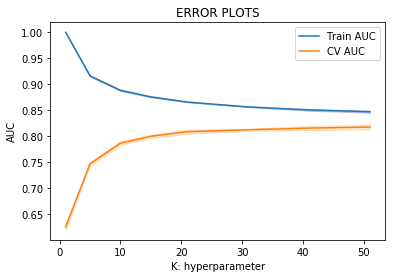

In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV


neigh = KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(tfidf_train_vectors, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 


In [224]:
best_k=14

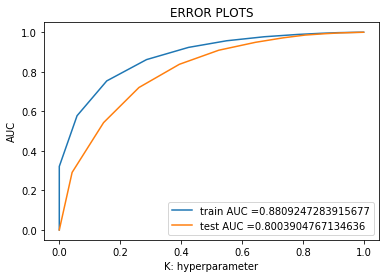

Train confusion matrix
[[ 1192  2457]
 [  429 18367]]
Test confusion matrix
[[  702  1957]
 [  390 13451]]


In [225]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(tfidf_train_vectors, y_train)
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(tfidf_train_vectors)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_test_vectors)))

# Variables for table 


TFIDF_Word2Vec_brute_K = best_k
TFIDF_Word2Vec_brute_train = train_auc
TFIDF_word2Vec_brute_test = cv_auc
 

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

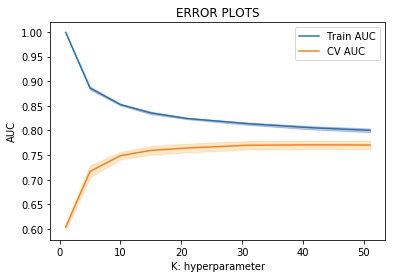

In [56]:
# Please write all the code with proper documentation
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
Xtrain_bow = svd.fit_transform(X_train_bow)
Xtest_bow = svd.transform(X_test_bow)


# Please write all the code with proper documentation
# Importing libraries
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier(algorithm='kd_tree')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(Xtrain_bow, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [226]:
best_k=41

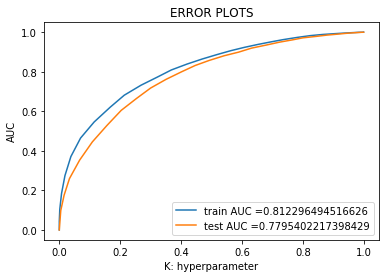

Train confusion matrix
[[  793  2856]
 [  487 18309]]
Test confusion matrix
[[  532  2127]
 [  393 13448]]


In [227]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(Xtrain_bow, y_train)
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(Xtrain_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(Xtest_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(Xtrain_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(Xtest_bow)))



# Variables for table 
bow_kdTree_K = best_k
bow_kdTree_train = train_auc
bow_kdTree_test = cv_auc

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

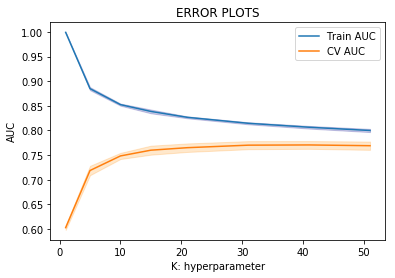

In [60]:
# Please write all the code with proper documentation
svd = TruncatedSVD(n_components=100)
Xtrain_tfidf = svd.fit_transform(X_train_bow)
Xtest_tfidf = svd.transform(X_test_bow)

# Please write all the code with proper documentation
# Importing libraries
from sklearn.model_selection import GridSearchCV


neigh = KNeighborsClassifier(algorithm='kd_tree')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(Xtrain_tfidf, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [228]:
best_k=31

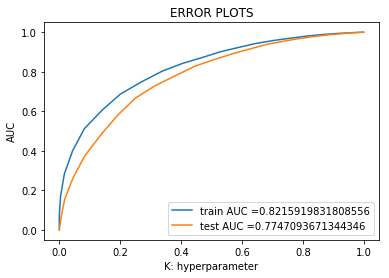

Train confusion matrix
[[  850  2799]
 [  537 18259]]
Test confusion matrix
[[  567  2092]
 [  450 13391]]


In [229]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(Xtrain_tfidf, y_train)

    
    
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(Xtrain_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(Xtest_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(Xtrain_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(Xtest_tfidf)))


# Variables for table 
tfidf_kdTree_K = best_k
tfidf_kdTree_train = train_auc
tfidf_kdTree_test = cv_auc


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 7</font>

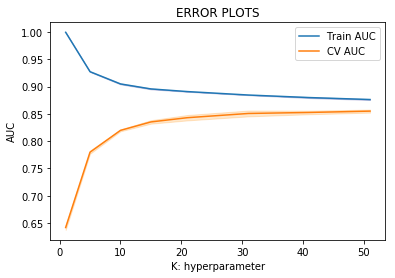

In [63]:
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier(algorithm='kd_tree')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(train_vectors, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [230]:
best_k=15

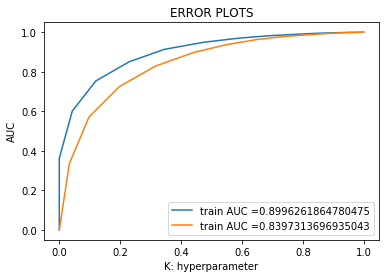

Train confusion matrix
[[ 1135  2514]
 [  333 18463]]
Test confusion matrix
[[  706  1953]
 [  304 13537]]


In [231]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(train_vectors, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(train_vectors)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(test_vectors)))



# Variables for table 
Avg_Word2Vec_kdTree_K = best_k
Avg_Word2Vec_kdTree_train = train_auc
Avg_Word2Vec_kdTree_test = cv_auc 


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 8</font>

---



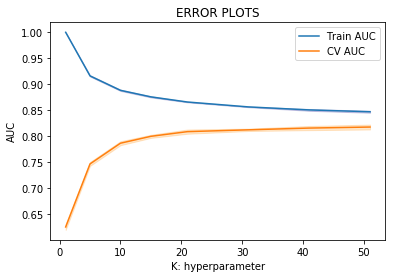

In [67]:
neigh = KNeighborsClassifier(algorithm='kd_tree')
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(tfidf_train_vectors, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()  


In [232]:
best_k=15

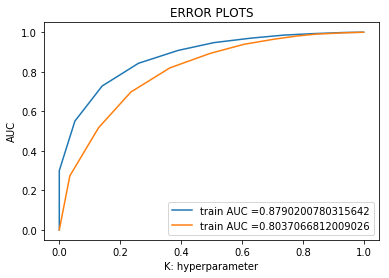

Train confusion matrix
[[  962  2687]
 [  276 18520]]
Test confusion matrix
[[  588  2071]
 [  269 13572]]


In [233]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(tfidf_train_vectors, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(tfidf_train_vectors)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_test_vectors)))

# Variables for table 
TFIDF_Word2Vec_kdTree_K = best_k
TFIDF_Word2Vec_kdTree_train = train_auc
TFIDF_Word2Vec_kdTree_test = cv_auc 
 

# [6] Conclusions

In [235]:
from prettytable import PrettyTable

# Initializing prettytable

ptable = PrettyTable()

names = ["brute for BoW", "kdTree for BoW", "brute for TFIDF", "kdTree' for TFIDF", "brute for Avg-Word2Vec", "kdTree for Avg-Word2Vec", \
        "brute for TFIDF-Word2Vec", "kdTree' for TFIDF-Word2Vec"]

k = ([bow_brute_K , bow_kdTree_K , tfidf_brute_K , tfidf_kdTree_K , Avg_Word2Vec_brute_K, Avg_Word2Vec_kdTree_K , \
            TFIDF_Word2Vec_brute_K , TFIDF_Word2Vec_kdTree_K ])

train = ([bow_brute_train, bow_kdTree_train, tfidf_brute_train, tfidf_kdTree_train, \
             Avg_Word2Vec_brute_train, Avg_Word2Vec_kdTree_train, TFIDF_Word2Vec_brute_train , \
             TFIDF_Word2Vec_kdTree_train])

test = ([bow_brute_test, bow_kdTree_test , tfidf_brute_test , tfidf_kdTree_test , \
            Avg_word2Vec_brute_test, Avg_Word2Vec_kdTree_test , TFIDF_word2Vec_brute_test, \
            TFIDF_Word2Vec_kdTree_test ])
 
ptable.add_column("MODEL",names)
ptable.add_column("K: hyperparameter",k)
ptable.add_column("Train",train)
ptable.add_column("Test",test)

# Printing the Table
print(ptable)

+----------------------------+-------------------+--------------------------------------------------------------------+--------------------------------------------------------------------+
|           MODEL            | K: hyperparameter |                               Train                                |                                Test                                |
+----------------------------+-------------------+--------------------------------------------------------------------+--------------------------------------------------------------------+
|       brute for BoW        |         10        | [0.99904082 0.87564734 0.83360146 0.81453208 0.80111969 0.78982963 | [0.61888499 0.69626005 0.71437932 0.72365154 0.72907095 0.73086155 |
|                            |                   |                       0.78554394 0.78689953]                       |                       0.73535048 0.74305482]                       |
|       kdTree for BoW       |         41        | [0.9